In [33]:
import pandas as pd
import numpy as np
import gensim.models.word2vec as w2v
import multiprocessing
import os
import re
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.manifold

In [107]:
songs = pd.read_csv("../datasets/songdata.csv", header=0)
#songs.head()
songs = songs[songs.artist != 'Lata Mangeshkar']
songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [108]:
arts_list = songs['artist'].unique()
print(len(arts_list))

642


In [109]:
my_arts=['The Beatles','Maroon 5','Lana Del Rey','Chris Brown','Green Day','David Guetta','Ellie Goulding','Ed Sheeran']

In [110]:
text_lenght = [0]*(len(my_arts))                                 # creating the subtable
my_lyrics = songs[songs.artist =='Maroon 5']
text_lenght[0] = len(my_lyrics)

for i in range(0, len(my_arts)):
    text_lenght[i]= len(songs[songs['artist']==my_arts[i]]['text'])
    my_lyrics = my_lyrics.append(songs[songs.artist ==my_arts[i]])
    i+=1

print(text_lenght)                               # Number of songs per chosen artist  
print(len(my_lyrics))  

[178, 110, 113, 145, 174, 63, 77, 53]
1023


,artist,song,link,text
12520,Maroon 5,Can't Stop,/m/maroon+5/cant+stop_20419103.html,All alone in my room think of you at a rate th...
12521,Maroon 5,Harder To Breathe,/m/maroon+5/harder+to+breathe_20089506.html,How dare you say that my behavior is unaccepta...
12522,Maroon 5,Highway To Hell,/m/maroon+5/highway+to+hell_10175468.html,"Living easy, livin' free \nSeason ticket, on ..."
12523,Maroon 5,If I Fell,/m/maroon+5/if+i+fell_10175467.html,If I fell in love with you \nWould you promis...
12524,Maroon 5,If You Only Knew,/m/maroon+5/if+you+only+knew_10175490.html,I wake up \nThoughts of you \nTattooed to my...


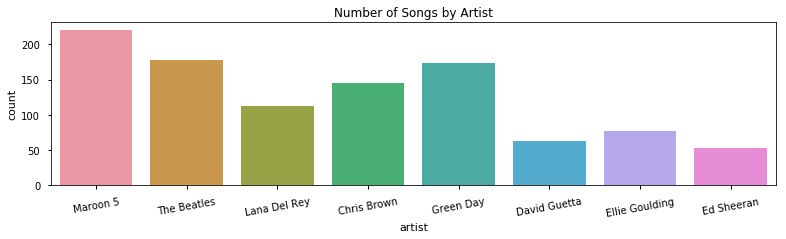

In [111]:
sns.set_context("notebook", font_scale=1.0)
sns.set_palette('cubehelix',4)         
plt.figure(figsize=(13,3))
plt.title('Number of Songs by Artist')
g = sns.countplot(my_lyrics['artist'])
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)                                        
my_lyrics.head()

In [112]:
print(arts_list[:10])

['ABBA' 'Ace Of Base' 'Adam Sandler' 'Adele' 'Aerosmith' 'Air Supply'
 'Aiza Seguerra' 'Alabama' 'Alan Parsons Project' 'Aled Jones']


In [113]:
from io import StringIO
warray = [['']]*8                  # Picking lists of most favorite words by artist
fav_words = [['']]*8
word_cnt = [0]*8
tfidf = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, stop_words='english')
i=0                                                    
for artist, sngs in my_lyrics.groupby('artist'):
    my_texts = songs[songs['artist']==my_arts[i]]['text']
    tfidf.fit_transform(my_texts)
    cnt = np.sum(tfidf.transform(sngs['text']).toarray(), axis=0)
    warray[i] = tfidf.get_feature_names()
    word_cnt[i] = len(warray[i])
    sort_freq = np.argsort(cnt.flatten())[::-1]   
    fav_words[i] = [tfidf.get_feature_names()[idx] for idx in sort_freq.tolist()[:40]]
    print(my_arts[i], "has the most favorite words :",fav_words[i],
         'and the number of unique words in all songs is:', word_cnt[i])
    i+=1 

('The Beatles', 'has the most favorite words :', [u'girl', u'wanna', u'don', u'love', u'chorus', u'like', u'baby', u'know', u'cause', u'just', u'got', u'let', u'need', u'ya', u'ain', u'oh', u'yeah', u'gotta', u'want', u'make', u'll', u'body', u'right', u'heart', u'tell', u'say', u'brown', u'way', u'come', u'think', u'time', u'man', u'money', u'bout', u'look', u'bad', u'life', u'gonna', u'hey', u'did'], 'and the number of unique words in all songs is:', 2028)
('Maroon 5', 'has the most favorite words :', [u'love', u'wanna', u'let', u'don', u'party', u'got', u'oh', u'dance', u'hear', u'just', u'hey', u'baby', u'yeah', u'make', u'like', u'feel', u'chorus', u'people', u'know', u'world', u'come', u'won', u'll', u'night', u'lights', u've', u'money', u'believe', u'right', u'hands', u'gotta', u'music', u'floor', u'way', u'life', u'bang', u'girl', u'live', u'tonight', u'say'], 'and the number of unique words in all songs is:', 1803)
('Lana Del Rey', 'has the most favorite words :', [u'll', u'lo

In [114]:
comb_texts = ['']*8            # concatenated texts of all songs by the artist
comb_length = [0]*8
i=0
j=0
mn=0
while (i!=sum(text_lenght)):
    comb_texts[j] += (my_lyrics.iloc[i]['text'])
    if (i == text_lenght[j]+ mn ):
        mn+=text_lenght[j]
        j+=1
    i+=1 
for l in range (0,8):
    comb_length[l] = len(comb_texts[l])    
print(comb_length)

[223098, 99931, 163169, 238686, 284453, 68489, 83079, 71653]


In [115]:
artists_stats = pd.DataFrame()
artists_stats['artist'] = my_arts
artists_stats['songs'] = text_lenght
artists_stats['words'] = word_cnt
artists_stats['all_length'] = comb_length
artists_stats

,artist,songs,words,all_length
0,The Beatles,178,2028,223098
1,Maroon 5,110,1803,99931
2,Lana Del Rey,113,2254,163169
3,Chris Brown,145,3251,238686
4,Green Day,174,2937,284453
5,David Guetta,63,1070,68489
6,Ellie Goulding,77,1479,83079
7,Ed Sheeran,53,1614,71653


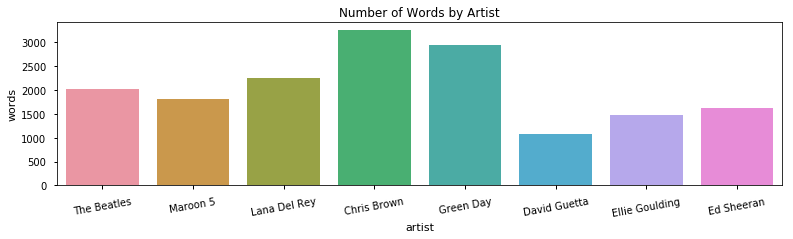

In [116]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,3))
plt.title('Number of Words by Artist')
g = sns.barplot( x='artist', y='words', data=artists_stats )
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)

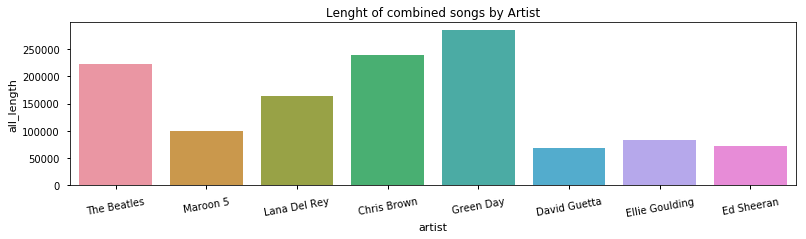

In [117]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,3))
plt.title('Lenght of combined songs by Artist')
g = sns.barplot( x='artist', y='all_length', data=artists_stats )
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)

In [118]:
topics = ['life','death','love','hate','dream','hell','light','dark',
          'heart','kill','party','miss','leave','break','lost']
topic_cnt = np.zeros((8,15), int)
i = 0                                    # setting short vocabulary positive/negative pairs
j = 0                                 
for text in comb_texts:
    for topic in topics:
        topic_cnt[i][j] = text.count(topic)
        j+=1
    j=0    
    i+=1
    
# def score_count(a,b,c,d,e,f,g,h,k,l):
#     return (100*(a+b+c+d+e)/(f+g+h+k+l))  

In [119]:
freq_df = pd.DataFrame(topic_cnt)
freq_df.rename(columns=lambda x: topics[int(x)], inplace=True)
freq_df['artist'] = my_arts
col_to_keep= ['artist','life','death','love','hate','dream','hell','light','dark',
          'heart','kill','party','miss','leave','break','lost']
freq_df = freq_df[col_to_keep]
# freq_df['mood'] =score_count(freq_df.life,freq_df.love,freq_df.dream,freq_df.light,
#                              freq_df.heart,freq_df.death,freq_df.hate,freq_df.hell,
#                              freq_df.dark,freq_df.kill)
freq_df                      # table of word frequencies by artist


,artist,life,death,love,hate,dream,hell,light,dark,heart,kill,party,miss,leave,break,lost
0,The Beatles,46,4,367,5,26,57,53,32,91,28,7,20,75,25,25
1,Maroon 5,28,0,228,12,26,15,22,5,32,1,3,7,26,8,6
2,Lana Del Rey,34,5,241,5,12,26,71,28,82,28,1,14,41,17,20
3,Chris Brown,76,5,389,33,52,12,79,28,53,18,48,19,52,24,11
4,Green Day,66,8,434,51,44,16,50,2,148,24,34,34,69,57,25
5,David Guetta,39,5,28,5,19,14,19,4,34,14,2,2,5,3,17
6,Ellie Goulding,30,4,119,17,9,20,47,3,37,7,53,5,16,10,20
7,Ed Sheeran,27,1,140,7,21,1,19,5,42,0,43,2,7,35,18


In [120]:
print (len(my_lyrics))
# print(songs.loc[songs.artist=='Ellie Goulding'])
# my_lyrics.loc[my_lyrics['artist']=='Maroon 5']['text']

1023


In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english')

arts_features= ['']*8            # concatenated texts of all songs by the artist
j=0
top_n = 25

while (j!=len(my_arts)):
    art_text= my_lyrics.loc[my_lyrics['artist']==my_arts[j]]['text']
    tfidf= tf.fit_transform(art_text)
    features=tf.get_feature_names()
    indices = np.argsort(tf.idf_)[::-1]
    top_features = [features[i] for i in indices[:top_n]]
    arts_features[j]=top_features
    print (my_arts[j])
    print (arts_features[j])
    print ("---------------------------------------")
    j+=1

The Beatles
[u'zu mir', u'head tuesday', u'headed pool', u'headed', u'head yawning', u'head won', u'head wish', u'head way', u'head try', u'helloa hela', u'head threw', u'head silly', u'head sea', u'head sand', u'head look', u'head like', u'heading', u'heading home', u'health dr', u'health said', u'hear balalaika', u'hear clock', u'hear comes', u'hear commonwealth', u'hear does']
---------------------------------------
Maroon 5
[u'zero like', u'impulsive makes', u'hard standing', u'hard stay', u'hard sunday', u'hard time', u'hard tried', u'hard try', u'hard waiting', u'harder bitter', u'harder breathe', u'harder everyday', u'harder harder', u'harder ooh', u'hardly', u'hardly know', u'hashtag', u'hashtag boo', u'hate', u'hate like', u'hate love', u'hates', u'hates life', u'hating', u'hating ll']
---------------------------------------
Lana Del Rey
[u'zoom miles', u'got want', u'got trouble', u'got thinking', u'got think', u'got things', u'got tested', u'got sweet', u'got sun', u'got sum

In [122]:
text_corpus = []
for song in songs['text']:
    words = song.lower().split()
    text_corpus.append(words)



# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 50
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7


downsampling = 1e-1

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

songs2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

songs2vec.build_vocab(text_corpus)
print (len(text_corpus))

57618


In [123]:
print (text_corpus[0])

['look', 'at', 'her', 'face,', "it's", 'a', 'wonderful', 'face', 'and', 'it', 'means', 'something', 'special', 'to', 'me', 'look', 'at', 'the', 'way', 'that', 'she', 'smiles', 'when', 'she', 'sees', 'me', 'how', 'lucky', 'can', 'one', 'fellow', 'be?', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'she', 'makes', 'me', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine?', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'without', 'her', "i'm", 'blue', 'and', 'if', 'she', 'ever', 'leaves', 'me', 'what', 'could', 'i', 'do,', 'what', 'could', 'i', 'do?', 'and', 'when', 'we', 'go', 'for', 'a', 'walk', 'in', 'the', 'park', 'and', 'she', 'holds', 'me', 'and', 'squeezes', 'my', 'hand', "we'll", 'go', 'on', 'walking', 'for', 'hours', 'and', 'talking', 'about', 'all', 'the', 'things', 'that', 'we', 'plan', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'she', 'makes', 'me', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine?', 

In [124]:
tot_ex= (sum(len(ix) for ix in text_corpus))

In [125]:
songs2vec.train(text_corpus,total_examples =songs2vec.corpus_count, epochs = songs2vec.iter)

if not os.path.exists("trained"):
    os.makedirs("trained")

songs2vec.save(os.path.join("trained", "songs2vectors.w2v"))

In [126]:
songs2vec = w2v.Word2Vec.load(os.path.join("trained", "songs2vectors.w2v"))

In [127]:
print(songs2vec['un-right'])
def songVector(row):
    vector_sum = 0
    words = row.lower().split()
    for word in words:
        vector_sum = vector_sum + songs2vec[word]
    vector_sum = vector_sum.reshape(1,-1)
    normalised_vector_sum = sklearn.preprocessing.normalize(vector_sum)
    return normalised_vector_sum

songs['song_vector'] = songs['text'].apply(songVector)

/Users/apple/Desktop/ml/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/Users/apple/Desktop/ml/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[ 0.11449661  0.05083022 -0.01556623  0.05904781  0.02657868 -0.05445872
 -0.00380397 -0.14984836  0.08251259  0.11111036 -0.03338833 -0.09088743
 -0.29768994 -0.02835776  0.06968899  0.0335472   0.14484954 -0.02005572
  0.08789431  0.02173861 -0.07767854 -0.02255011 -0.11934733  0.21216038
 -0.04667437  0.04151644 -0.04186783  0.0936831  -0.1801589   0.08834203
 -0.03317815  0.0265792  -0.01254152  0.0818755  -0.0644341   0.08559451
 -0.05821166  0.11871001  0.18930197 -0.02679446 -0.01486963 -0.07970905
 -0.01954713  0.04975018  0.038105    0.05499194  0.24064425  0.07432903
  0.11451775  0.00571623]


In [152]:
song_vectors = []
from sklearn.model_selection import train_test_split

train, test = train_test_split(songs, test_size = 0.9)


for song_vector in train['song_vector']:
    song_vectors.append(song_vector)

train.head(10)



,artist,song,link,text,song_vector
40219,The Killers,Runaways,/k/killers/runaways_21020386.html,Blonde hair blowin' in the summer wind \nA bl...,"[[0.266954, 0.0412763, 0.00462736, 0.0279123, ..."
34885,Guided By Voices,Not Behind The Fighter Jet,/g/guided+by+voices/not+behind+the+fighter+jet...,Militant babies came to me \nAnd tole me don'...,"[[0.307401, 0.0125137, -0.0470018, 0.0735526, ..."
53888,Tragically Hip,Courage,/t/tragically+hip/courage_10235554.html,Watch the band through a bunch of dancers \nQ...,"[[0.27038, 0.037072, -0.0547066, 0.0246341, 0...."
2270,Cat Stevens,Kitty,/c/cat+stevens/kitty_20028164.html,"I work in the mornin', I work in the night \n...","[[0.319113, 0.0321593, 0.00623209, 0.0356212, ..."
15160,Our Lady Peace,Shaking,/o/our+lady+peace/shaking_20103712.html,So you fucked this up again \nIt's time for y...,"[[0.277093, 0.00587201, -0.017085, 0.0265259, ..."
49728,R. Kelly,Hook It Up,/r/r+kelly/hook+it+up_20433223.html,"She look what? \nShe look good, she bad as a ...","[[0.199032, 0.04327, 0.000395201, 0.0360167, 0..."
29371,Def Leppard,On Through The Night,/d/def+leppard/on+through+the+night_20038906.html,"The wait is done, the battle's won \nSo count...","[[0.302048, 0.0581304, -0.00543682, 0.0353168,..."
2980,Christmas Songs,"Jingle, Jingle, Jingle",/c/christmas+songs/jingle+jingle+jingle_206742...,"Jingle, jingle, jingle \nYou will hear my sle...","[[0.30934, -0.0174022, 0.0136537, -0.0653621, ..."
25633,Black Sabbath,Shock Wave,/b/black+sabbath/shock+wave_20019408.html,There's no reason for you to run \nYou can't ...,"[[0.304295, 0.0113192, -0.0455718, 0.0447866, ..."
740,Andy Williams,A Fool Never Learns,/a/andy+williams/a+fool+never+learns_20007899....,"A fool never learns \nTo get away, just run a...","[[0.277331, 0.000420484, 0.0283839, -0.0174258..."


In [129]:
X = np.array(song_vectors).reshape((5761, 50))
tsne = sklearn.manifold.TSNE(n_components=2, n_iter=600, random_state=1, verbose=2)

all_word_vectors_matrix_2d = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5761 samples in 0.267s...
[t-SNE] Computed neighbors for 5761 samples in 5.693s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5761
[t-SNE] Computed conditional probabilities for sample 2000 / 5761
[t-SNE] Computed conditional probabilities for sample 3000 / 5761
[t-SNE] Computed conditional probabilities for sample 4000 / 5761
[t-SNE] Computed conditional probabilities for sample 5000 / 5761
[t-SNE] Computed conditional probabilities for sample 5761 / 5761
[t-SNE] Mean sigma: 0.052962
[t-SNE] Computed conditional probabilities in 0.524s
[t-SNE] Iteration 50: error = 87.3106384, gradient norm = 0.0165897 (50 iterations in 18.426s)
[t-SNE] Iteration 100: error = 87.2407913, gradient norm = 0.0282462 (50 iterations in 12.521s)
[t-SNE] Iteration 150: error = 86.9732132, gradient norm = 0.0069237 (50 iterations in 11.479s)
[t-SNE] Iteration 200: error = 86.9049606, gradient norm = 0.0151499 (50 iterations in 11.264s

In [130]:
df=pd.DataFrame(all_word_vectors_matrix_2d,columns=['X','Y'])

df.head(10)

train.head()

df.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [131]:
X.shape

(5761, 50)

In [132]:
all_word_vectors_matrix_2d.shape

(5761, 2)

In [134]:
# two_dimensional_songs = pd.concat([train, df], axis=1)

two_dimensional_songs.head(10)

,artist,song,link,text,song_vector,X,Y
0,Kirk Franklin,Till We Meet Again,/k/kirk+franklin/till+we+meet+again_20319586.html,May His peace be with you till we meet again ...,"[[0.312917, 0.0442185, 0.00263426, -0.0488817,...",-1.759031,29.516600
1,Proclaimers,The Thought Of You,/p/proclaimers/the+thought+of+you_21057572.html,The thought of you \nPrecious and clear \nDr...,"[[0.277476, 0.0144161, -0.0134141, -0.00672466...",4.271090,11.665915
2,Van Halen,Amsterdam,/v/van+halen/amsterdam_20142752.html,Looking good through the window \nShinin' red...,"[[0.143526, 0.0562009, 0.0536499, 0.0961068, -...",-8.790691,-26.429245
3,Celine Dion,Love Is All We Need,/c/celine+dion/love+is+all+we+need_20248331.html,She was living in a perfect house \nWith pict...,"[[0.288607, 0.0288042, -0.00752149, 0.030522, ...",-7.708698,4.204097
4,Hollies,Fortune Teller,/h/hollies/fortune+teller_20065664.html,(Neville) \nWent to a fortune teller \nTo ha...,"[[0.275887, 0.000581642, 0.0164549, 0.00857466...",23.162333,-5.196386
5,Nina Simone,Cherish,/n/nina+simone/cherish_20167040.html,Cherish is the word I use to describe \nAll t...,"[[0.269493, -0.00669602, 0.00603891, 0.0030669...",-26.420053,8.580839
6,Frankie Goes To Hollywood,Get It On,/f/frankie+goes+to+hollywood/get+it+on_2070552...,"Well you're dirty and sweet, clad in black. \...","[[0.264573, 0.047744, -0.0424196, -0.0108557, ...",-6.864091,-24.920717
7,Alabama,Jukebox In My Mind,/a/alabama/jukebox+in+my+mind_20005127.html,[Chorus] \nIn the corner of my mind stands a ...,"[[0.301816, -0.00224504, 0.00214301, 0.0264286...",3.094590,18.113592
8,Natalie Cole,Your Lonely Heart,/n/natalie+cole/your+lonely+heart_10189863.html,Here you are right by my side \nWords cannot ...,"[[0.235774, 0.041872, 0.0162653, -0.0238469, 0...",-18.888086,-6.054028
9,The Killers,Heart Of A Girl,/k/killers/heart+of+a+girl_21020383.html,Looking out my window \nAn angel in robes app...,"[[0.283803, 0.0347537, -0.0240625, 0.0440827, ...",14.979512,4.793198


In [135]:
(two_dimensional_songs['X'])[0]

-1.7590311

In [136]:
from sklearn.neighbors import NearestNeighbors
train_knn=np.zeros((two_dimensional_songs.shape[0],2))

train_knn[:,0]=two_dimensional_songs['X']
train_knn[:,1]=two_dimensional_songs['Y']
print (train_knn[:10,:])

[[ -1.75903106  29.51659966]
 [  4.27109003  11.66591549]
 [ -8.79069138 -26.429245  ]
 [ -7.70869827   4.20409679]
 [ 23.16233253  -5.19638586]
 [-26.42005348   8.58083916]
 [ -6.8640914  -24.92071724]
 [  3.09459019  18.11359215]
 [-18.88808632  -6.05402803]
 [ 14.97951221   4.79319811]]


In [147]:
# songs[songs.artist =='Lana Del Rey']
songs[songs.song =='Summertime Sadness']
# songs[songs.song =='Love']

,artist,song,link,text,song_vector
41226,Lana Del Rey,Summertime Sadness,/l/lana+del+rey/summertime+sadness_20992968.html,Kiss me hard before you go \nSummertime sadne...,"[[0.233945, 0.059165, 0.0165871, 0.0294158, -0..."
56712,Within Temptation,Summertime Sadness,/w/within+temptation/summertime+sadness_210739...,Kiss me hard before you go \nSummertime sadne...,"[[0.225661, 0.065292, 0.0157442, 0.0428567, -0..."


In [201]:
two_dimensional_songs.loc[two_dimensional_songs['artist']=='Maroon 5']
# two_dimensional_songs.loc[two_dimensional_songs['song']=='Never Let Me Go',['X','Y']]
# two_dimensional_songs.ix[:,['X','Y']]

,artist,song,link,text,song_vector,X,Y
540,Maroon 5,Not Coming Home,/m/maroon+5/not+coming+home_20089508.html,When you refuse me \nYou confuse me \nWhat m...,"[[0.265595, 0.012222, -0.00198203, -0.00998326...",-26.191322,0.059568
844,Maroon 5,Last Chance,/m/maroon+5/last+chance_20890560.html,I'm sure that he could give you everything \n...,"[[0.251094, 0.0275056, 0.0294173, -0.0090897, ...",-29.442862,-9.924737
1732,Maroon 5,"To Her, With Love",/m/maroon+5/to+her+with+love_20614291.html,See my dear I'm thinking of you \nMy how she ...,"[[0.268644, 0.0219739, -0.0184696, -0.00724982...",-8.162704,17.915344
1980,Maroon 5,Lucky Strike,/m/maroon+5/lucky+strike_21016121.html,"You're such a motivator, I gotta get you here ...","[[0.25381, 0.0182908, 0.0497482, 0.0308286, 0....",-6.503418,-23.263102
2333,Maroon 5,Through With You,/m/maroon+5/through+with+you_10175478.html,Can you see me \nFloating above your head \n...,"[[0.262463, 0.02475, 0.0017821, 0.0144639, -0....",-29.273048,1.507630
3794,Maroon 5,Coming Back For You,/m/maroon+5/coming+back+for+you_21087244.html,Looking at the same sky that we used to live u...,"[[0.231002, 0.0570337, 0.0130114, 0.0205543, -...",-32.180923,-7.140160
4125,Maroon 5,Love Somebody,/m/maroon+5/love+somebody_21016123.html,I know your insides are feeling so hollow \nA...,"[[0.25029, 0.0655114, 0.0522937, 0.00015991, -...",-29.511093,-11.053373
4580,Maroon 5,I Don't Want To Know,/m/maroon+5/i+dont+want+to+know_21111185.html,"[Verse 1] \nWasted the more I think, the more...","[[0.21999, 0.05624, 0.0209975, 0.0184944, 0.00...",-30.305136,-13.462815
4888,Maroon 5,Better That We Break,/m/maroon+5/better+that+we+break_20419133.html,I never knew perfection till \nI heard you sp...,"[[0.273675, 0.0381906, -0.0368116, 0.0115048, ...",-13.423188,-9.526529
5095,Maroon 5,Sunday Morning,/m/maroon+5/sunday+morning_20089512.html,"Sunday morning, rain is falling \nSteal some ...","[[0.302404, 0.0601126, 0.0016724, 0.000601901,...",0.552925,2.339357


In [ ]:
def l2_norm(x1,points_arr):
    dist_arr=np.sqrt(((b-a)**2).sum(axis=1))
    return dist_arr.argsort()[:3]
    
x1=np.array(two_dimensional_songs.loc[two_dimensional_songs['song']=='Love Somebody',['X','Y']])
points_arr=np.array(two_dimensional_songs.ix[:,['X','Y']])
min_indices = (l2_norm(x1,points_arr))

In [242]:
a=np.array([1,2])
b=np.array([[4,2],[2,3],[4,7],[3,6]])
print (np.sqrt(((b-a)**2)))
print (np.sqrt(((b-a)**2).sum(axis=1)))
print (np.sqrt(((b-a)**2).sum(axis=1))).argsort()[:3]

[[ 3.  0.]
 [ 1.  1.]
 [ 3.  5.]
 [ 2.  4.]]
[ 3.          1.41421356  5.83095189  4.47213595]
[1 0 3]


In [222]:
# print (two_dimensional_songs.loc[two_dimensional_songs['song']=='Sunday Morning'])
print (min['dist'])
two_dimensional_songs.loc[two_dimensional_songs['X']==min['points'][0]]

67.2072


,artist,song,link,text,song_vector,X,Y
5760,Sting,Gabriel's Message,/s/sting/gabriels+message_20203291.html,The angel Gabriel from heaven came \nHis wing...,"[[0.201599, -0.0754914, 0.0776389, -0.111984, ...",17.981939,36.498924


In [187]:
arr=np.array([2,5,3,4,6])
print (arr.argsort()[:3])

[0 2 3]


In [220]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

trace1 = go.Scatter(
    y = two_dimensional_songs['Y'],
    x = two_dimensional_songs['X'],
    text = two_dimensional_songs['song'],
    mode='markers',
    marker=dict(
        size='7',
        color = np.random.randn(5717), #set color equal to a variable
        colorscale='RdYlBl',
        showscale=True
    )
)
data = [trace1]

iplot(data)